In [ ]:
# Для набора данных blood_cells.
# ( вариант 1 использовать ссгенерированные данные)
##################
# Решите задачу сегментации  и подсчет количества клеток.
# Алгоритм 1. Метод Хафа для поиска окружностей.
# Алгоритм 2. Алгоритм водораздел+карта расстояний для сегментации пересекающихся объектов.
##################
# Показатели качества решения задачи сегментации: accuracy, precision. Усреднить по количеству изображений теста.
# min количество изобаржений для тестирования - 10.

In [ ]:
!unzip /content/generated_data.zip -d /content/

Archive:  /content/generated_data.zip
   creating: /content/generated_data/
  inflating: /content/generated_data/clean_1772.png  
  inflating: /content/generated_data/clean_3062.png  
  inflating: /content/generated_data/clean_3217.png  
  inflating: /content/generated_data/clean_4093.png  
  inflating: /content/generated_data/clean_4282.png  
  inflating: /content/generated_data/clean_4972.png  
  inflating: /content/generated_data/clean_6253.png  
  inflating: /content/generated_data/clean_6558.png  
  inflating: /content/generated_data/clean_7667.png  
  inflating: /content/generated_data/clean_7903.png  
  inflating: /content/generated_data/clean_8031.png  
  inflating: /content/generated_data/clean_8249.png  


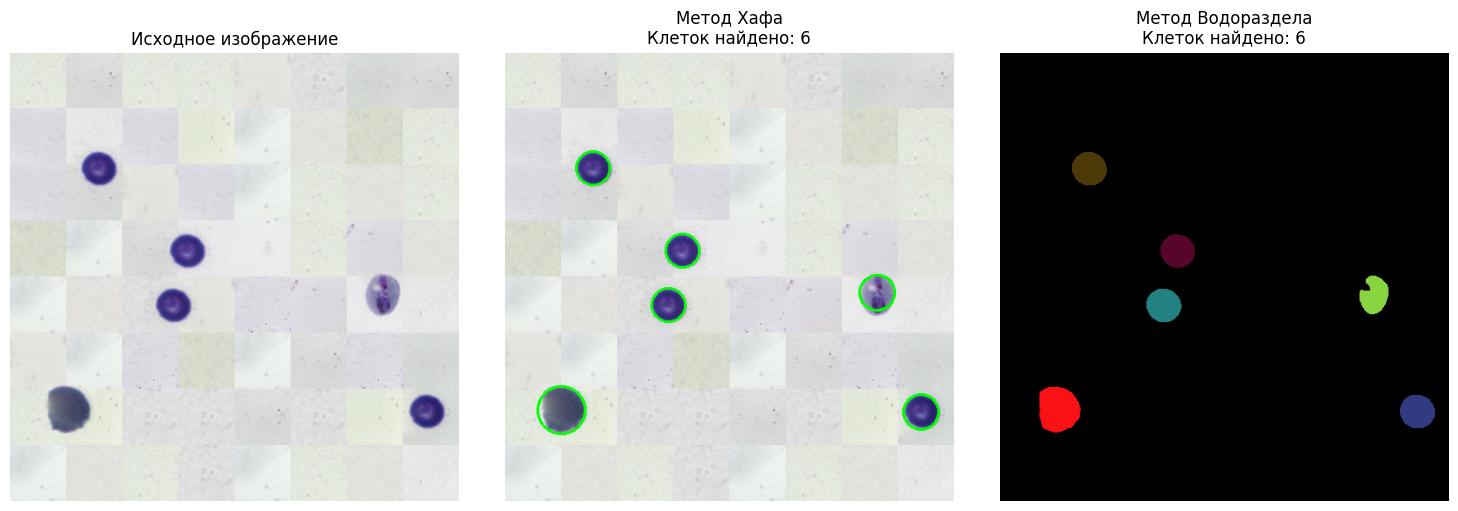

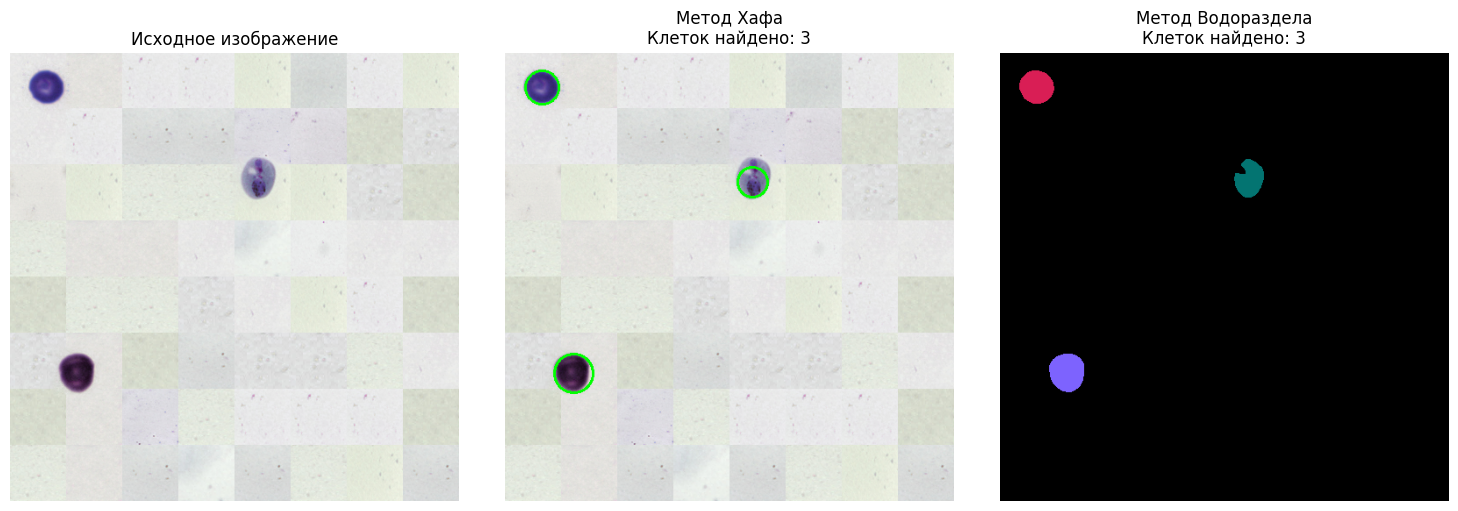

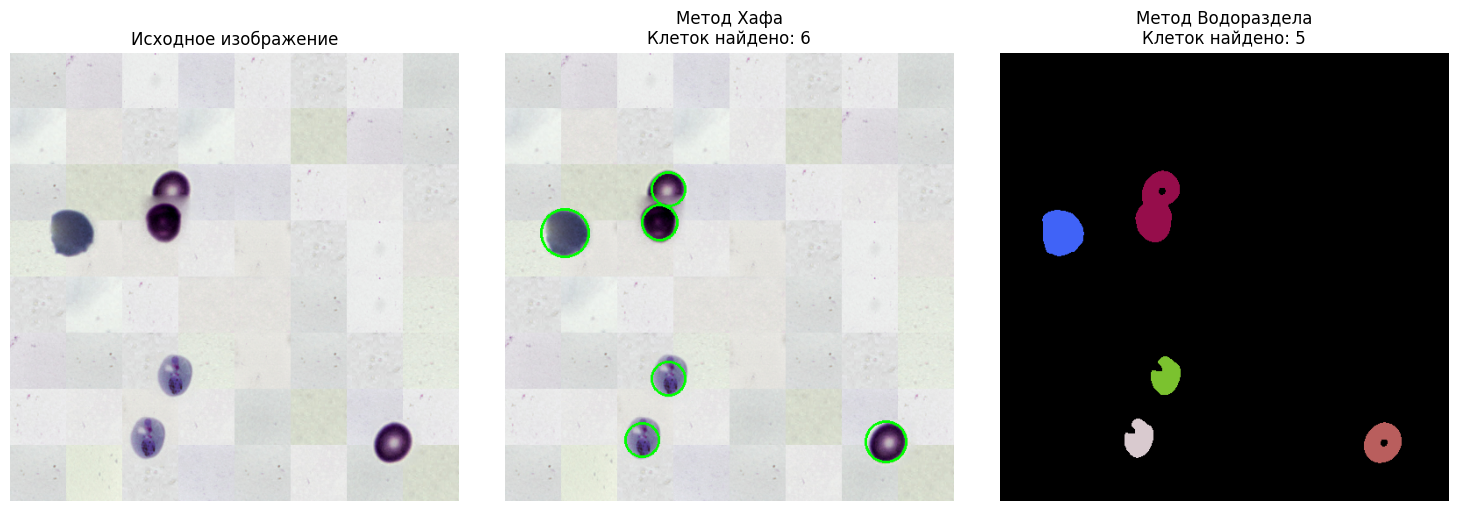

Введите количество клеток на изображении 1: 6
Введите количество клеток на изображении 2: 3
Введите количество клеток на изображении 3: 6

=== Итоговые показатели качества ===
Метод Хафа - Accuracy: 1.00, Precision: 1.00
Метод Водораздела - Accuracy: 0.94, Precision: 1.00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import random
import glob

def load_images_from_folder(folder_path, num_images=3):
    images = []
    filenames = glob.glob(f"{folder_path}/*.png") + glob.glob(f"{folder_path}/*.jpg")
    random.shuffle(filenames)  # Перемешиваем для случайного выбора

    for filename in filenames[:num_images]:
        img = cv2.imread(filename)
        if img is not None:
            images.append(img)

    return images

def hough_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=25, minRadius=10, maxRadius=50)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        return len(circles[0])  # Количество найденных клеток
    return 0

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Бинаризация
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Морфологические операции для удаления шума
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Карта расстояний
    distance = ndimage.distance_transform_edt(binary)
    coords = peak_local_max(distance, min_distance=20, labels=binary)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True

    # Маркеры для водораздела
    markers, _ = ndimage.label(mask)
    labels = watershed(-distance, markers, mask=binary)

    return labels  # Возвращаем карту сегментации

def evaluate_segmentation(real_counts, predicted_counts):
    accuracy_list = []
    precision_list = []

    for real, predicted in zip(real_counts, predicted_counts):
        TP = min(real, predicted)
        FP = max(0, predicted - real)
        FN = max(0, real - predicted)

        accuracy = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0

        accuracy_list.append(accuracy)
        precision_list.append(precision)

    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)

    return avg_accuracy, avg_precision

# Загружаем 3 тестовых изображения
test_images = load_images_from_folder("/content/generated_data", num_images=3)

hough_counts = []
watershed_counts = []
watershed_labels = []

# Визуализация всех изображений
for i, img in enumerate(test_images):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Оригинальное изображение
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Исходное изображение")
    axes[0].axis("off")

    # Метод Хафа
    hough_img = img.copy()
    gray = cv2.cvtColor(hough_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 7)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=25, minRadius=10, maxRadius=50)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            cv2.circle(hough_img, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)

    hough_counts.append(hough_transform(img))

    axes[1].imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Метод Хафа\nКлеток найдено: {hough_counts[-1]}")
    axes[1].axis("off")

    # Метод Водораздела
    labels = watershed_segmentation(img)
    watershed_labels.append(labels)
    watershed_counts.append(len(np.unique(labels)) - 1)

    segmented_img = np.zeros_like(img, dtype=np.uint8)

    # Красим разные сегменты в разные цвета для визуализации
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == 0:
            continue  # Игнорируем фон
        mask = labels == label
        color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
        segmented_img[mask] = color

    axes[2].imshow(segmented_img)
    axes[2].set_title(f"Метод Водораздела\nКлеток найдено: {watershed_counts[-1]}")
    axes[2].axis("off")

    plt.tight_layout()

    plt.show()

# Ввод реального количества клеток после всех изображений
real_counts = []
for i in range(len(test_images)):
    while True:
        try:
            real_count = int(input(f"Введите количество клеток на изображении {i+1}: "))
            if real_count >= 0:
                real_counts.append(real_count)
                break
            else:
                print("Ошибка: введите неотрицательное число.")
        except ValueError:
            print("Ошибка: введите целое число.")

# Оценка качества
acc_hough, prec_hough = evaluate_segmentation(real_counts, hough_counts)
acc_watershed, prec_watershed = evaluate_segmentation(real_counts, watershed_counts)

print("\n=== Итоговые показатели качества ===")
print(f"Метод Хафа - Accuracy: {acc_hough:.2f}, Precision: {prec_hough:.2f}")
print(f"Метод Водораздела - Accuracy: {acc_watershed:.2f}, Precision: {prec_watershed:.2f}")
